In [ ]:
!pip install -q --upgrade \
  transformers \
  datasets accelerate scikit-learn evaluate \
  huggingface_hub sentencepiece openpyxl tqdm


import transformers as _tf, transformers.utils as _u, huggingface_hub as _hub
_u.get_cached_models      = getattr(_u, "get_cached_models", lambda *a, **k: [])
_u.get_file_from_repo     = getattr(_u, "get_file_from_repo", _hub.hf_hub_download)
_u.is_soundfile_available = getattr(_u, "is_soundfile_available", lambda *a, **k: False)
_u.is_soundfile_availble  = getattr(_u, "is_soundfile_availble", lambda *a, **k: False)
if not hasattr(_tf, "EncoderDecoderCache"):
    class EncoderDecoderCache: pass
    _tf.EncoderDecoderCache = EncoderDecoderCache
print("✅ transformers", _tf.__version__, "parcheado")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.1/362.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import pandas as pd
root_dir = "/content/drive/MyDrive/PDG/data/"

df_train = pd.read_excel(root_dir + "train_df.xlsx")
df_val   = pd.read_excel(root_dir + "val_df.xlsx")
df_test  = pd.read_excel(root_dir + "test_df.xlsx")

TEXT_COL  = "texto"
LABEL_COL = "etiqueta"

for df in (df_train, df_val, df_test):
    df[ LABEL_COL ] = df[LABEL_COL].astype(int)


Mounted at /content/drive


In [ ]:
from datasets import Dataset
from transformers import RobertaTokenizerFast, default_data_collator

MODEL_NAME = "PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"
tok = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tok(batch[TEXT_COL], truncation=True, padding="max_length", max_length=256)

def to_ds(df):
    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize, batched=True, remove_columns=[TEXT_COL])
    ds = ds.rename_column(LABEL_COL, "labels")
    extra = [c for c in ds.column_names if c.startswith("__index_level_")]
    return ds.remove_columns(extra) if extra else ds

ds_train, ds_val, ds_test = map(to_ds, (df_train, df_val, df_test))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/540k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

Map:   0%|          | 0/2634 [00:00<?, ? examples/s]

Map:   0%|          | 0/659 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
import torch, torch.nn.functional as F
from transformers import (
    RobertaForSequenceClassification, Trainer, TrainingArguments
)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import math



counts = df_train[LABEL_COL].value_counts().sort_index().values
alpha  = torch.tensor(counts.sum() / (2.0 * counts), dtype=torch.float)

class FocalLoss(torch.nn.Module):
    def __init__(self, alpha, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, labels):
        ce = F.cross_entropy(logits, labels, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce)
        return ((1 - pt) ** self.gamma * ce).mean()

model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_alpha=None, **k):
        super().__init__(*args, **k)
        self.loss_alpha = loss_alpha.to(self.args.device)


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        loss = FocalLoss(self.loss_alpha)(outputs.logits, labels)
        return (loss, outputs) if return_outputs else loss

def metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(1)
    p, r, f, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0,1])
    return {"accuracy": accuracy_score(labels, preds),
            "precision": p[1], "recall": r[1], "f1": f[1]}

args = TrainingArguments(
    output_dir               = "/content/critico_clf",
    num_train_epochs         = 4,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 16,
    learning_rate            = 2e-5,
    weight_decay             = 0.01,
    logging_steps            = 50,
    seed                     = 42,
    fp16                     = torch.cuda.is_available(),


    do_train                 = True,
    do_eval                  = True,
    eval_steps               = math.ceil(len(ds_train) / 8),
    save_steps               = math.ceil(len(ds_train) / 8),
    save_total_limit         = 2,
)

trainer = CustomTrainer(
    model           = model,
    args            = args,
    train_dataset   = ds_train,
    eval_dataset    = ds_val,
    tokenizer       = tok,
    data_collator   = default_data_collator,
    compute_metrics = metrics,
    loss_alpha      = alpha,
)

trainer.train()


pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-4-58336f4b6eef>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **k)


model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: annsof (annsof-universidad-icesi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.246300
100,0.156300
150,0.125400
200,0.102600
250,0.127400
300,0.059500
350,0.098800
400,0.153000
450,0.046500
500,0.079300


TrainOutput(global_step=1320, training_loss=0.07854399567074848, metrics={'train_runtime': 100.7122, 'train_samples_per_second': 104.615, 'train_steps_per_second': 13.107, 'total_flos': 1386069039636480.0, 'train_loss': 0.07854399567074848, 'epoch': 4.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix




print("\n=== Desempeño en VALIDACIÓN durante el entrenamiento ===")
val_logits, val_labels, _ = trainer.predict(ds_val)
val_preds = val_logits.argmax(axis=1)
print(classification_report(val_labels, val_preds,
                            target_names=["No crítico", "Crítico"],
                            digits=4))

cm_val = confusion_matrix(val_labels, val_preds)
tn, fp, fn, tp = cm_val.ravel()
vpn_val = tn / (tn + fn) if (tn + fn) > 0 else 0.0
print(f"VPN (Valor predictivo negativo) en VALIDACIÓN: {vpn_val:.4f}")


print("\n=== Desempeño en TEST final ===")
test_logits, test_labels, _ = trainer.predict(ds_test)
test_preds = test_logits.argmax(axis=1)
print(classification_report(test_labels, test_preds,
                            target_names=["No crítico", "Crítico"],
                            digits=4))

cm_test = confusion_matrix(test_labels, test_preds)
tn_t, fp_t, fn_t, tp_t = cm_test.ravel()
vpn_test = tn_t / (tn_t + fn_t) if (tn_t + fn_t) > 0 else 0.0
print(f"VPN (Valor predictivo negativo) en TEST: {vpn_test:.4f}")



=== Desempeño en VALIDACIÓN durante el entrenamiento ===


              precision    recall  f1-score   support

  No crítico     0.9789    0.9551    0.9669       535
     Crítico     0.8248    0.9113    0.8659       124

    accuracy                         0.9469       659
   macro avg     0.9019    0.9332    0.9164       659
weighted avg     0.9499    0.9469    0.9479       659

VPN (Valor predictivo negativo) en VALIDACIÓN: 0.9789

=== Desempeño en TEST final ===


              precision    recall  f1-score   support

  No crítico     0.9615    0.9259    0.9434        81
     Crítico     0.7273    0.8421    0.7805        19

    accuracy                         0.9100       100
   macro avg     0.8444    0.8840    0.8619       100
weighted avg     0.9170    0.9100    0.9124       100

VPN (Valor predictivo negativo) en TEST: 0.9615



Matriz de confusión — VALIDACIÓN
[[511  24]
 [ 11 113]]


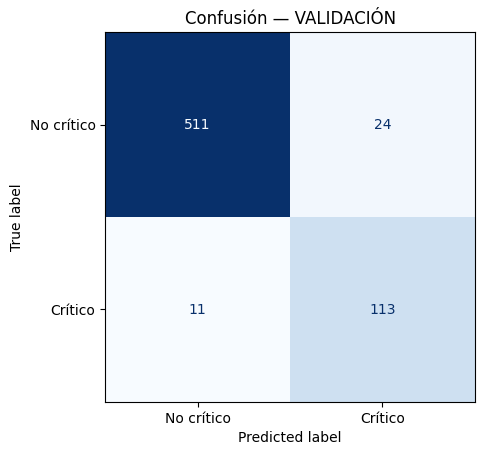


Matriz de confusión — TEST
[[75  6]
 [ 3 16]]


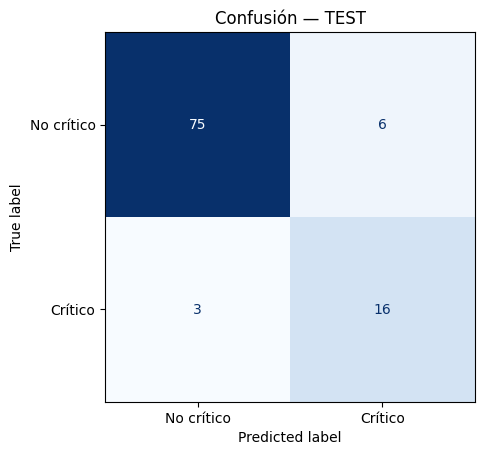

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


print("\nMatriz de confusión — VALIDACIÓN")
print(cm_val)

disp_val = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=["No crítico", "Crítico"]
)
disp_val.plot(cmap="Blues", colorbar=False)
plt.title("Confusión — VALIDACIÓN")
plt.show()


print("\nMatriz de confusión — TEST")
print(cm_test)

disp_test = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=["No crítico", "Crítico"]
)
disp_test.plot(cmap="Blues", colorbar=False)
plt.title("Confusión — TEST")
plt.show()
